Author: Carlos Roberto de Melo

Obj: MGE parametrization for NFW profile.

The classical spherical NFW profile is:
<center> $\rho(r) = \frac{\rho_s}{(r/r_s)  (1 + r/r_s)^2 }$.
    
    
But in terms of the critical surface density,
<center> $\Sigma_{crit} = \frac{c^2}{4\pi G} \frac{D_l}{D_s D_{ls}}$    
    
we have:
<center> $\rho(r) = \frac{\kappa_s \Sigma_{crit}}{r(1 + r/r_s)^2 }$,

where: $\kappa_s = \frac{\rho_s r_s}{\Sigma_{crit}}$.
    
To obtain the elliptical mass profile, we had to replace the radial coordinate $r = \sqrt{x^2 + y^2}$, by a elliptical one $r_e = \sqrt{x^2 + y^2/q^2}$, where $q$ is the axial ratio assuming that the semi major  axis of the ellipse is in the x-axis.
    
The MGE parameterization is particularly useful in this case, because we can parametrize the Spherical profile, and then just adjuste the projected axial ratio in the final output. But in case of you don't trust me (even if you trust, I strongly recommend a quick look) , you can check the comparison in the _MGE with Analytical Profiles_ folder.
 
Beside that, we set here $\kappa_s = 1.00$, so if you want to re-scale the NFW total mass you only have to re-scale this parameter (assuming that you don't want to change the scale radius).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mgefit import mge_fit_1d                                       #MGE 1-d parametrization
from jampy.mge_half_light_isophote import mge_half_light_isophote   #Compute half light radius
from jampy.mge_half_light_isophote import mge_half_light_radius     #Compute half light radius (other way)
from jampy import mge_radial_mass                                   #Compute mass inside some radius

from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
from astropy import table

from astropy.cosmology import Planck15
from astropy.constants import G, M_sun, c
import astropy.units as u
from scipy.integrate import quad

In [2]:
def Sph_NFW_lens(kappa_s, r_s, den_crit, r):
    """
        Classical Spherical NFW profile, usually used in lensing models. Here, the profile is writed in terms of
        kappa_s, which is a constant scale factor defined above in this notebook.
    """
    return (kappa_s * den_crit) / (r * (1 + r/r_s)**2 )


In [8]:
metre2Mpc = (1*u.m).to(u.Mpc)/u.m             #Constant factor to convert metre to Mpc.
kg2Msun   = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun


G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

In [9]:
#Redshift
z_l = 0.299 
z_s = 3.100

#Angular diametre distances
D_l  = Planck15.angular_diameter_distance(z_l)
D_s  = Planck15.angular_diameter_distance(z_s)
D_ls = Planck15.angular_diameter_distance_z1z2(z_l, z_s)

#NFW parameters

critical_density = ((c_Mpc**2/(4*np.pi*G_Mpc)) * (D_l/(D_ls * D_s))).to(u.solMass/u.pc**2) #Lens Critical Density
kappa_s = 1.000                                                                #Lens scale factor [Ad]
r_s     = ( (10 * 1.15 * u.arcsec) * D_l ).to(u.pc, u.dimensionless_angles())  #Scale radius      [pc]

r = np.logspace(-2.5, 7.5, 300) #Radii [pc]
print("Min: %.3e arcs, Max: %.3e arcs" %( r.min()/(D_l.value*np.pi/0.648), r.max()/(D_l.value*np.pi/0.648) ))

Min: 6.900e-07 arcs, Max: 6.900e+03 arcs


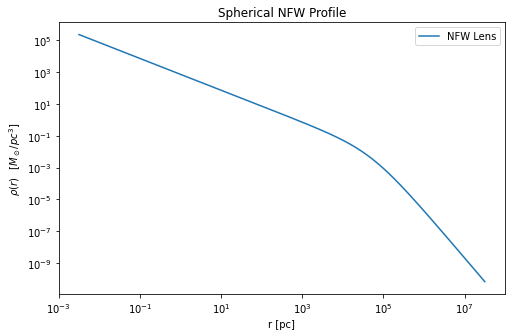

In [10]:
NFW_profile_lens = Sph_NFW_lens(kappa_s, r_s.value, critical_density.value, r)

plt.figure(figsize=(8,5))
plt.loglog(r, NFW_profile_lens, label="NFW Lens")

plt.title("Spherical NFW Profile")
plt.xlabel("r [pc]")
plt.ylabel("$\\rho(r)$ $\\,$ [$M_\\odot$/$pc^3$]")
plt.legend()

## MGE parametrization

Iteration: 1  chi2: 0.09534 Nonzero: 30/30
Iteration: 11  chi2: 0.02228 Nonzero: 30/30
Iteration: 21  chi2: 0.01686 Nonzero: 30/30
Iteration: 31  chi2: 0.01517 Nonzero: 30/30
Iteration: 41  chi2: 0.0147 Nonzero: 30/30
Iteration: 51  chi2: 0.01468 Nonzero: 30/30
Iteration: 52  chi2: 0.01468 Nonzero: 30/30
############################################
 Computation time: 2.11 seconds
 Total Iterations:  52
Nonzero Gaussians:  30
 Unused Gaussians:  0
 Chi2: 0.01468 
 STDEV: 0.006994
 MEANABSDEV: 0.006275
############################################
 Total_Counts      Sigma
############################################
      1316.33   0.00246503
      1294.59   0.00591309
      1287.49    0.0140813
         1282    0.0333927
      1277.79     0.078931
      1274.77     0.186118
       1272.9     0.438145
      1272.13      1.03053
      1272.39      2.42344
       1273.6      5.70192
      1275.61      13.4303
      1278.19       31.683
      1280.84       74.877
      1282.53      177.234
 

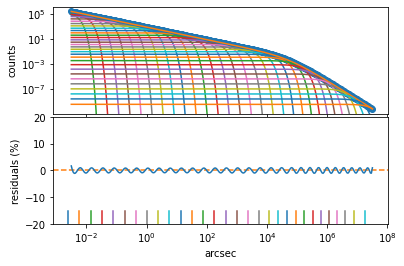

In [15]:
m = mge_fit_1d.mge_fit_1d(r, NFW_profile_lens, ngauss=30, outer_slope=2, plot=True)

In [18]:
#Converting quantities
surf  =  m.sol[0]                           # Surface density in Msun/pc**2
sigma = m.sol[1]/(D_l.value*np.pi/0.648)    # Gaussian dispersion in arcsec
qObs  = np.full_like(surf, 0.85)            # Assume elliptical model with q_obs = 0.85

In [19]:
#Transforming Surface Density to Total Mass
distance  = D_l                        # Distance in Mpc
surf_dm   = surf * u.solMass/u.pc**2
sigma_ARC = sigma * u.arcsec           #sigma in arcsec
sigma_PC  = (sigma_ARC * distance).to(u.pc, u.dimensionless_angles()) #Convert sigma in arcsec to sigma in pc

#Total DM mass per gaussian in M_sun
Mass = 2 * np.pi * surf_dm * (sigma_PC**2) * qObs
print(f"Total mass:{Mass.sum():0.03e}")

Total mass:1.273e+14 solMass


In [20]:
#Saving parametrization
np.savetxt('eNFW.txt', np.column_stack([surf, sigma, qObs]),
                            fmt=b'%5.5e\t\t\t %5.5e\t\t %5.5e', 
                            header='Surface Potential(M_sun/pc²) Sigma Potential(arcsec)    qObs')